In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [7]:
! cp -r ./drive/MyDrive/ESM/esm/* .

In [ ]:
import random
from collections import Counter
from tqdm import tqdm

import torch
from torch import nn 
from torch.utils.data import Dataset,DataLoader,TensorDataset


import numpy as np
import pandas as pd
import seaborn as sns

import esm

import matplotlib.pyplot as plt
from scipy.stats import pearsonr

In [3]:
data_mul = pd.read_csv("./multiple_muts_train.csv", )
data_single = pd.read_csv("./single_muts_train.csv")

data = pd.concat((data_mul, data_single), axis=0)
data["name"] = ["protein" + str(i) for i in range(data.shape[0])]

data = data.loc[:, ["name", "secondary_structure", "stabilityscore"]]
data.reset_index(drop=True, inplace=True)


# Store the proteins as .fasta file
with open("dataset.fasta", "w") as f:
    for i in range(data.shape[0]):
        f.write(">"+data.loc[i, "name"]+"\n")
        f.write(data.loc[i, "sequence"]+"\n"

In [4]:
nan_list = []
for i in range(data.shape[0]):
  if np.isnan(np.array(data.loc[i, "stabilityscore"])):
    nan_list.append(i)
data = data.drop(nan_list)
data.reset_index(drop=True, inplace=True)

In [6]:
data.shape

(37706, 3)

In [10]:
device = "cuda"

In [ ]:
! python extract.py esm1b_t33_650M_UR50S dataset.fasta ./train_all_reprs/ --include per_tok

In [11]:
SS = []
dict = {"H": 0, "E": 1, "T": 2}
for i in range(data.shape[0]):
  ss = data.loc[i, "secondary_structure"]
  s = np.array([dict[ss[i]] for i in range(len(ss))])
  SS.append(torch.from_numpy(s))


## Predict Contact Maps

In [ ]:
!pip install git+https://github.com/facebookresearch/esm.git
!curl -O https://dl.fbaipublicfiles.com/fair-esm/examples/P62593_reprs.tar.gz
!tar -xzf P62593_reprs.tar.gz
!curl -O https://dl.fbaipublicfiles.com/fair-esm/examples/P62593.fasta
!pwd
!ls
!pip install Bio
!git clone https://github.com/facebookresearch/esm

import sys
PATH_TO_REPO = "../"
sys.path.append(PATH_TO_REPO)

In [ ]:
import matplotlib.pyplot as plt
import esm
import torch
import os
from Bio import SeqIO
import itertools
from typing import List, Tuple
import string
import math

In [ ]:
esm1b, esm1b_alphabet = esm.pretrained.esm1b_t33_650M_UR50S()
esm1b = esm1b.eval().cuda()
esm1b_batch_converter = esm1b_alphabet.get_batch_converter()

In [ ]:
esm1b_data = []
for i in range(data.shape[0]):
  esm1b_data.append((data.loc[i, "name"], data.loc[i, "sequence"]))

contacts = []
torch.set_grad_enabled(False)
for i in range(math.ceil(len(esm1b_data) / 10)):

  esm1b_batch_labels, esm1b_batch_strs, esm1b_batch_tokens = esm1b_batch_converter(esm1b_data[10 * i : 10 * (i + 1)])
  esm1b_batch_tokens = esm1b_batch_tokens.cuda()
  esm1b_contacts = esm1b.predict_contacts(esm1b_batch_tokens).cpu()
  contacts.append(esm1b_contacts)
torch.set_grad_enabled(False)
contacts = torch.cat(contacts, dim=0)

## Training

In [30]:

EMB_PATH = "./train_all_reprs/"
EMB_LAYER = 33

class ProteinData(Dataset):
        
    def __len__(self):
        return data.shape[0]
    
    def __getitem__(self,i):
        x = torch.load(EMB_PATH + data.loc[i, "name"] + ".pt")["representations"][33]
        
        c = contacts[i, :, :]
        y = data.loc[i, "stabilityscore"]
        label = torch.tensor(y).float()
        return (x,label,c)

    
ds_train = ProteinData()



In [32]:
train_size = int(len(ds_train) * 0.7)
test_size = len(ds_train) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(ds_train, [train_size, test_size], generator=torch.Generator().manual_seed(42))

dl_train = DataLoader(train_dataset, batch_size = 128, shuffle=True, drop_last=True)
dl_test = DataLoader(test_dataset, batch_size = 128, shuffle=True, drop_last=True)

In [122]:
class LSTMs(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm1 = nn.LSTM(input_size = 1280, 
                             hidden_size = 100,
                             num_layers = 2,
                             batch_first = True,
                             bidirectional = True,
                             dropout = 0.3
                            )
        
        self.lstm2 = nn.LSTM(input_size = 200, 
                             hidden_size = 50,
                             num_layers = 2,
                             batch_first = True,
                             bidirectional = True,
                             dropout = 0.3
                            )
        self.lstm3 = nn.LSTM(input_size = 200, 
                             hidden_size = 50,
                             num_layers = 2,
                             batch_first = True,
                             bidirectional = True,
                             dropout = 0.3
                            )
        self.linear1 = nn.Linear(100, 20)
        self.linear2 = nn.Linear(20, 1)
        self.cont_w = nn.Parameter(torch.randn([1, 43, 43]))
        self.cont_b = nn.Parameter(torch.randn([1, 43, 43]))

    def forward(self, x, cont):
        cont = self.cont_w * cont + self.cont_b

        y = self.lstm1(x)[0]
        y = self.lstm2(y)[0]
        y2 = torch.matmul(cont, y)
        y = torch.cat((y, y2), dim=2)
        y = self.lstm3(y)[0]
        y = torch.mean(y, dim=1)
        y = self.linear1(y)
        y = self.linear2(y)

        return y
        


In [123]:
model = LSTMs().to(device)

for m in model.modules():
    if isinstance(m, (nn.Linear)):
        nn.init.kaiming_normal_(m.weight)
    if isinstance(m, (nn.LSTM)):
        for name, param in m.named_parameters():
          if 'weight' in name:
            nn.init.orthogonal_(param)
                
model.load_state_dict(torch.load("./drive/MyDrive/ESM/LSTM_with_Contact_Map.pkl"))


In [124]:
Loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01, weight_decay=0.)

In [125]:
def clip_gradient(optimizer, grad_clip):
    for group in optimizer.param_groups:
        for param in group["params"]:
            if param.grad is not None:
                param.grad.data.clamp_(-grad_clip, grad_clip)

In [127]:
def train_step(model, features, labels, ss):

    model.train()

    optimizer.zero_grad()

    predictions = model(features.to(device), ss.to(device))
    loss = Loss(predictions, labels.reshape(-1, 1).to(device))
    loss.backward()
    clip_gradient(optimizer, 10)
    optimizer.step()

    pccs = pearsonr(predictions.reshape(-1).detach().cpu().numpy(), labels.reshape(-1).detach().cpu().numpy())
    return loss.item(), pccs[0]

def valid_step(model, features, labels, ss):

    model.eval()

    with torch.no_grad():
        predictions = model(features.to(device), ss.to(device))
        loss = Loss(predictions, labels.reshape(-1, 1).to(device))
    
    return loss.item(), predictions


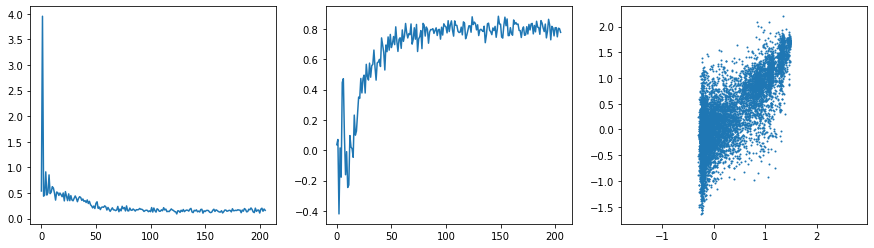

valid loss:  0.1507260056043213
valid correlation:  0.8011476774691293
sota!


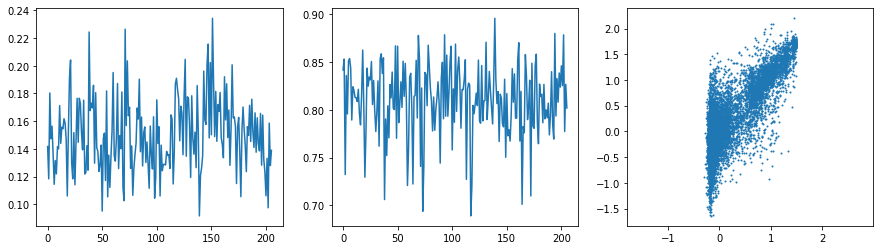

valid loss:  0.140502772801979
valid correlation:  0.8173165051154718
sota!


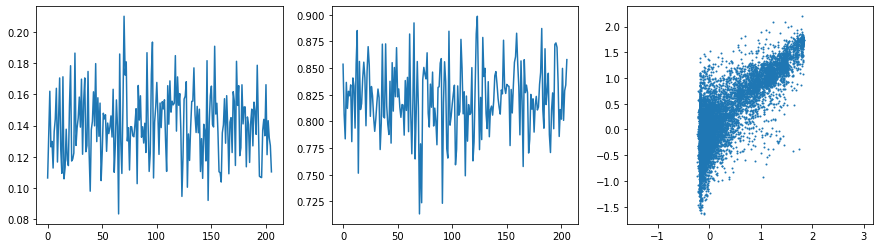

valid loss:  0.14047501227733764
valid correlation:  0.8218871360575251
sota!


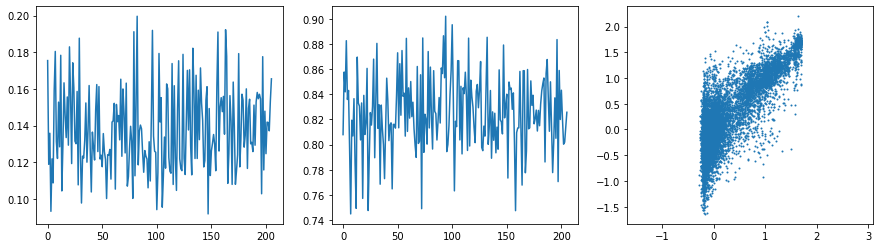

valid loss:  0.13550966360013594
valid correlation:  0.8227553373781437
sota!


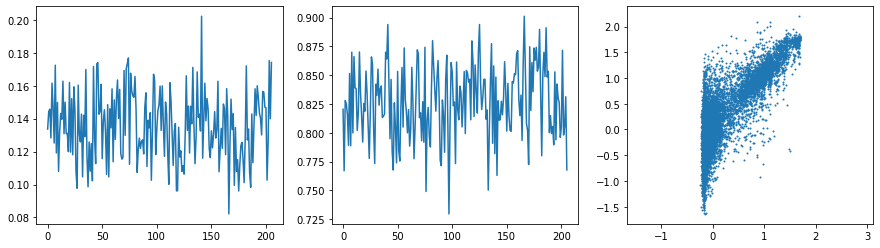

valid loss:  0.13665473393418573
valid correlation:  0.8234057921790517
sota!


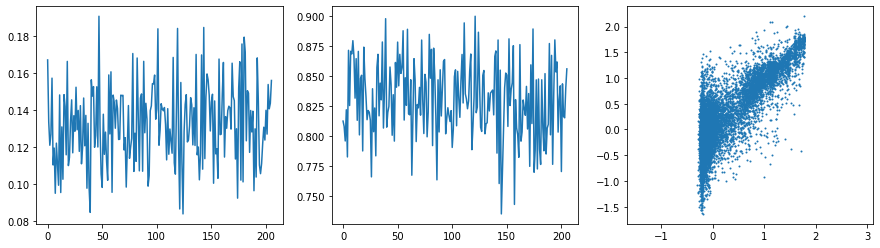

valid loss:  0.13520039939744907
valid correlation:  0.8255902335863856
sota!


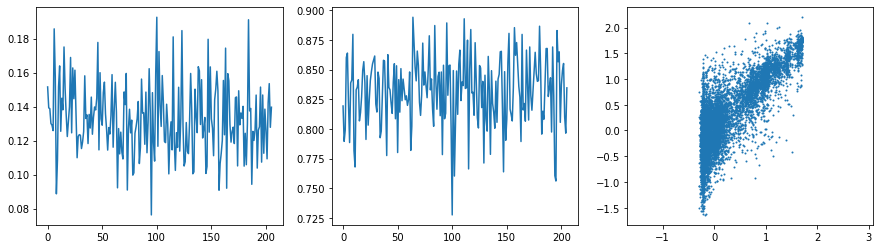

valid loss:  0.13253336755389516
valid correlation:  0.827689934251876
sota!


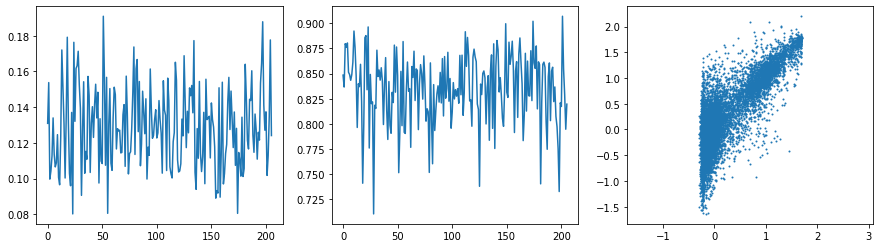

valid loss:  0.1309634574096311
valid correlation:  0.8296764680447366
sota!


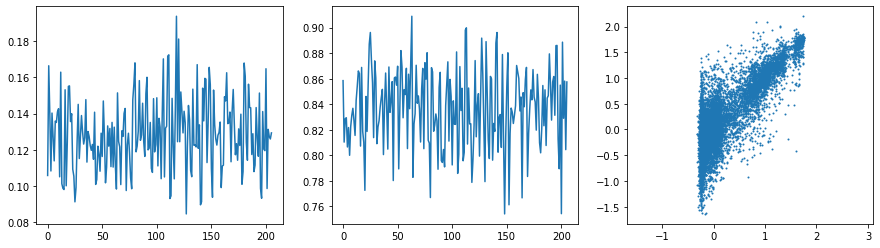

valid loss:  0.12992108088325371
valid correlation:  0.8305105419352161
sota!


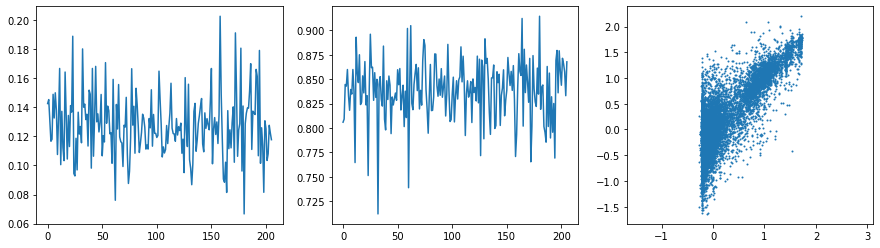

valid loss:  0.1293727040968158
valid correlation:  0.8309086919038724
sota!


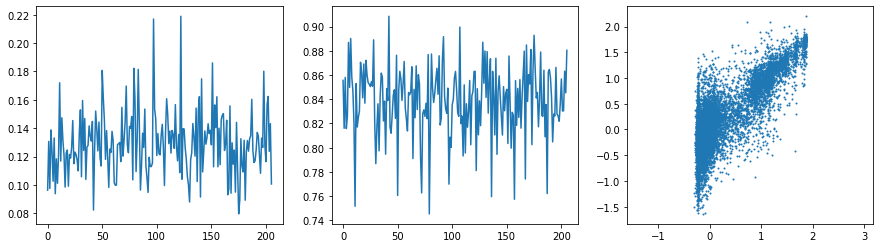

valid loss:  0.14002209901809692
valid correlation:  0.8270680644884204


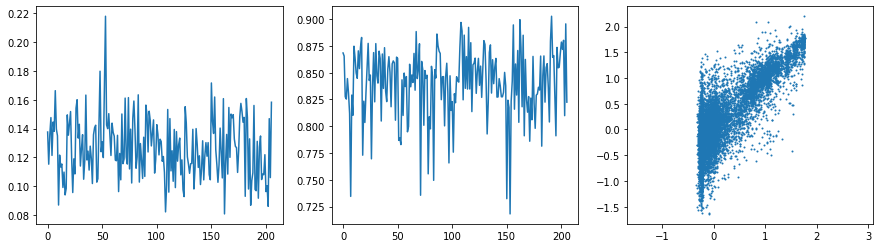

valid loss:  0.1305577726188031
valid correlation:  0.8311295925311407
sota!


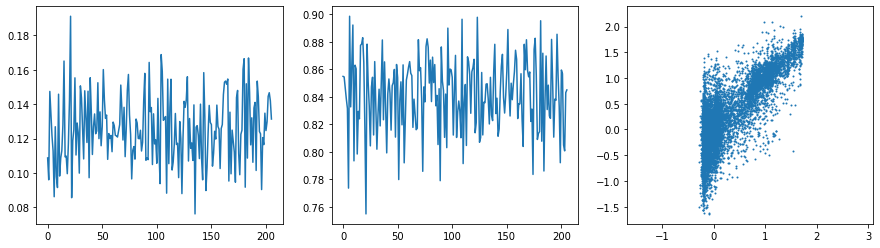

valid loss:  0.13016609923744743
valid correlation:  0.830621936823777


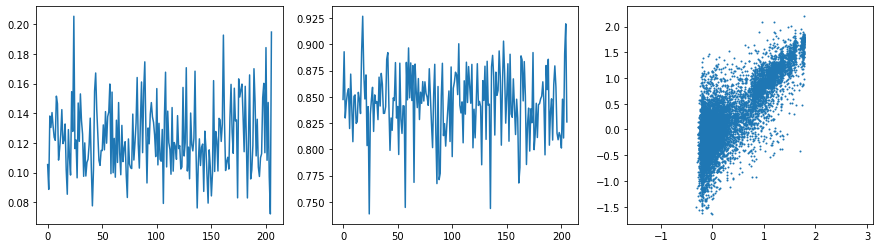

valid loss:  0.14489891397004778
valid correlation:  0.8269294004609146


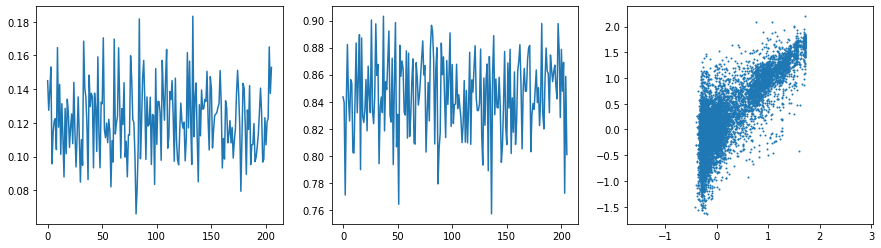

valid loss:  0.131744140335782
valid correlation:  0.8328838561050317
sota!


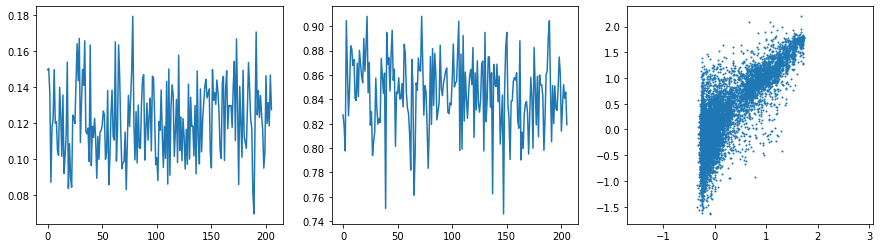

valid loss:  0.1312461941587654
valid correlation:  0.8302072308993257


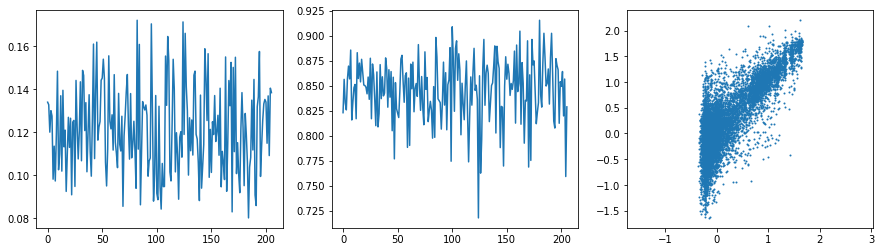

valid loss:  0.1297885626554489
valid correlation:  0.8324597977757655


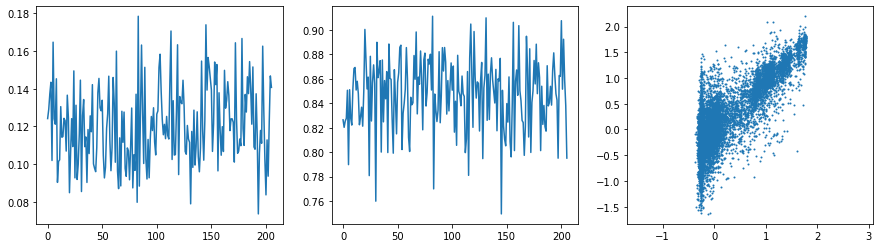

valid loss:  0.13376213491640307
valid correlation:  0.8314934285120804


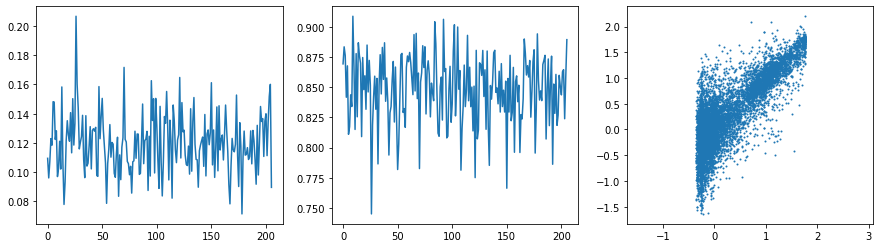

valid loss:  0.1296687297184359
valid correlation:  0.8340282347411578
sota!


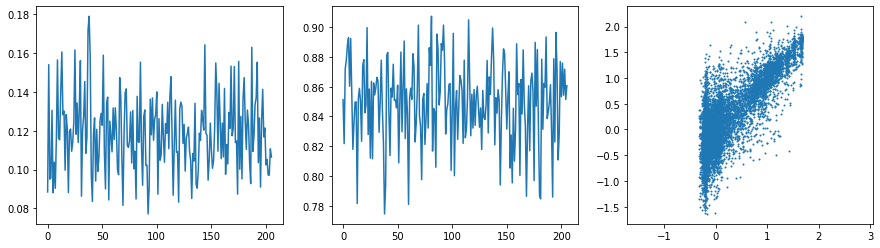

valid loss:  0.1296369576488029
valid correlation:  0.8308006943771218


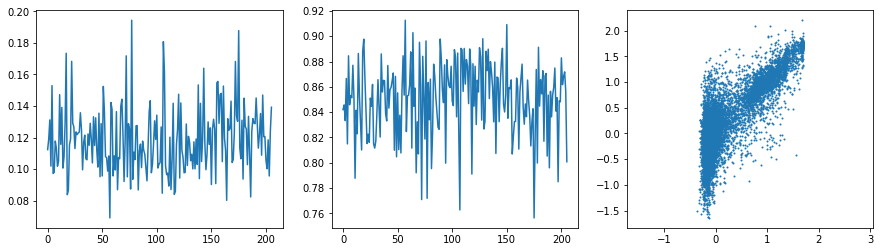

valid loss:  0.12874186784029007
valid correlation:  0.8322488582504126


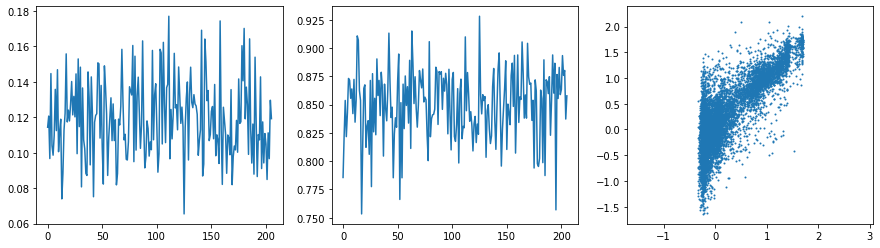

valid loss:  0.1293998614630916
valid correlation:  0.8331814101434116


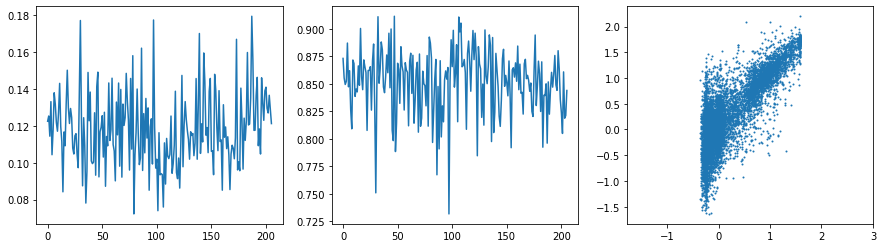

valid loss:  0.13049672129140658
valid correlation:  0.8349894925435266
sota!


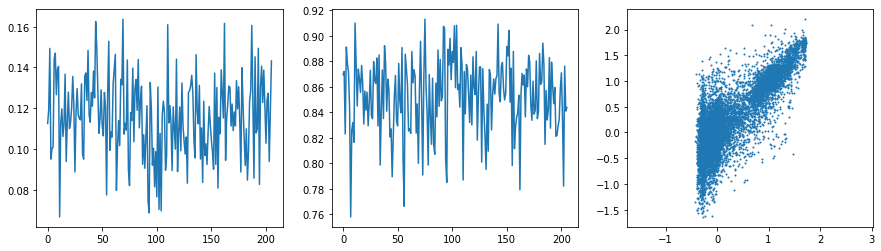

valid loss:  0.13110114583237606
valid correlation:  0.8316509644904357


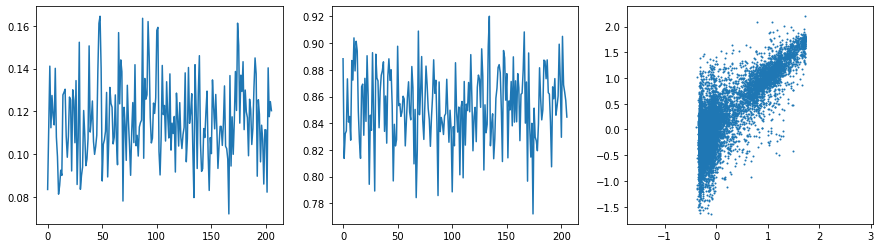

valid loss:  0.13188437558710575
valid correlation:  0.8325581960198982


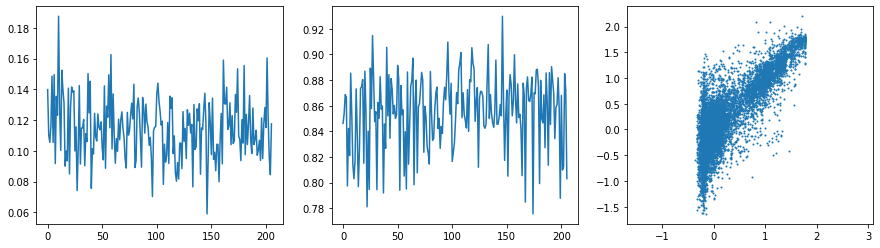

valid loss:  0.12616612990810114
valid correlation:  0.8359337339941416
sota!


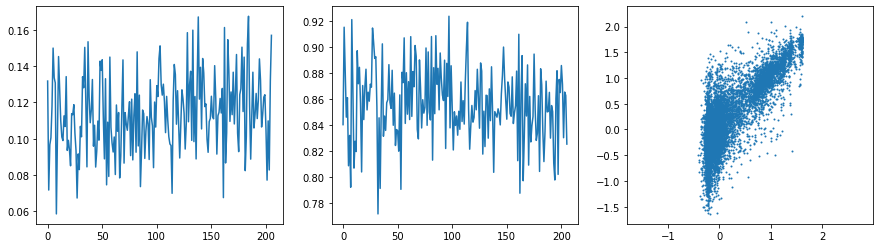

valid loss:  0.12978581796315583
valid correlation:  0.83228881529954


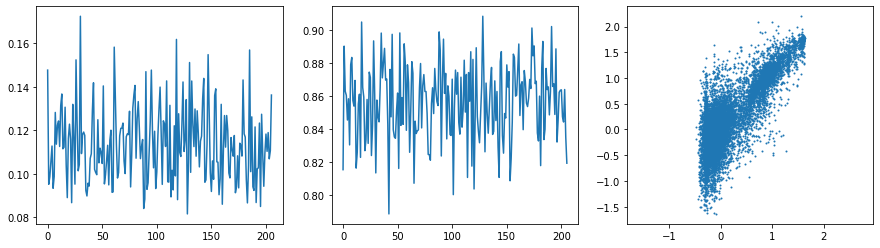

valid loss:  0.1314992711625316
valid correlation:  0.8304664523827976


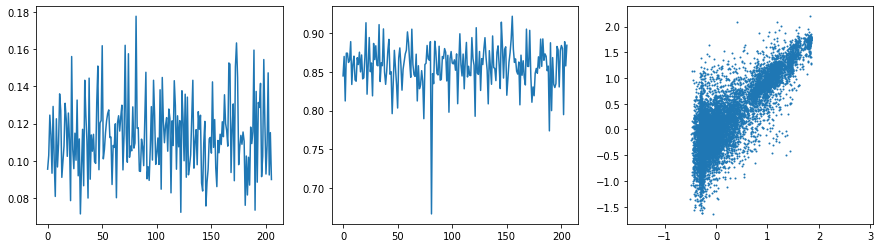

valid loss:  0.13347314670681953
valid correlation:  0.832223516519258


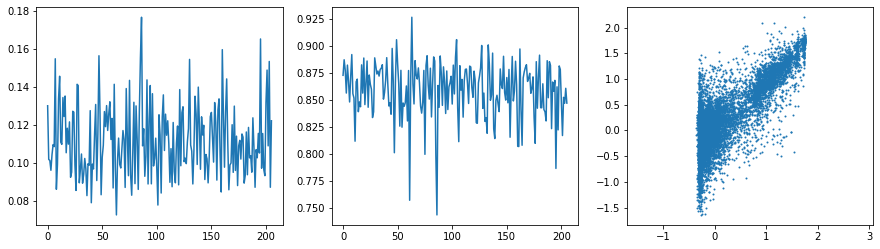

valid loss:  0.1344145734540441
valid correlation:  0.8321542115408816


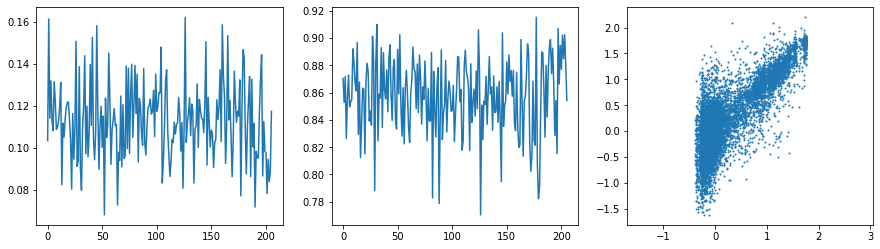

valid loss:  0.12964630067687144
valid correlation:  0.8323875197526086


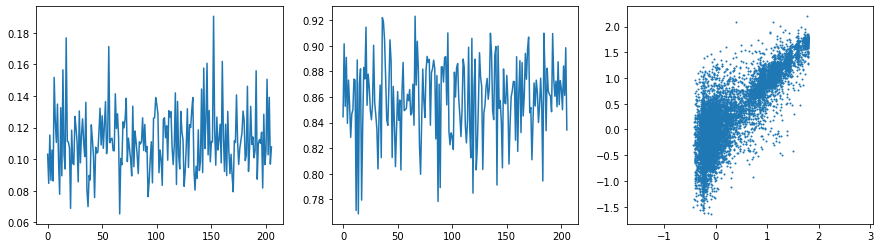

valid loss:  0.13006638540801677
valid correlation:  0.8335702884445256


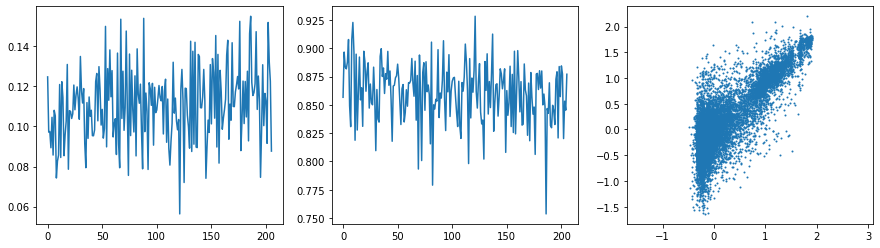

valid loss:  0.13540464267134666
valid correlation:  0.8313741979444216


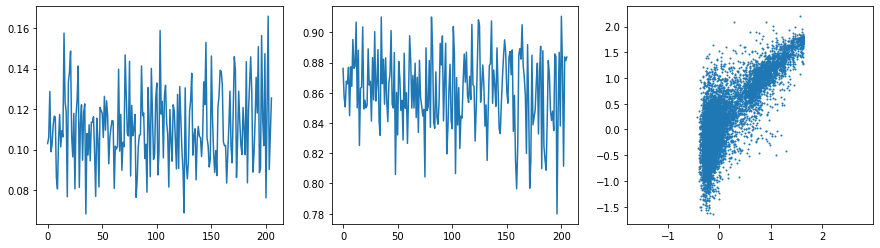

valid loss:  0.13612063389948822
valid correlation:  0.8317474373507344


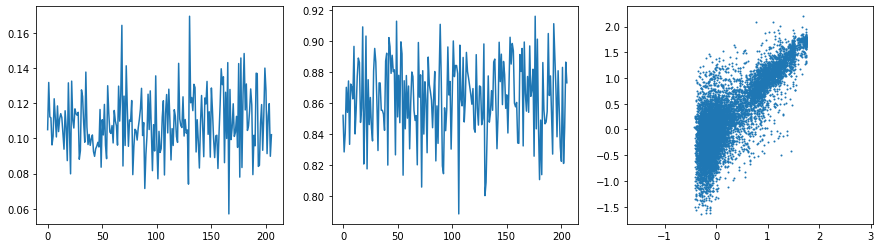

valid loss:  0.12791614471511406
valid correlation:  0.8338850404435952


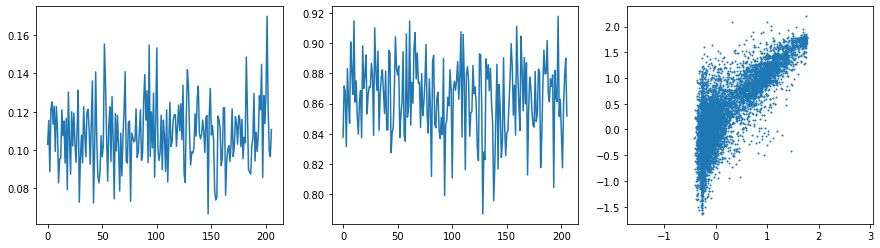

valid loss:  0.1389147246425802
valid correlation:  0.8289028935632607


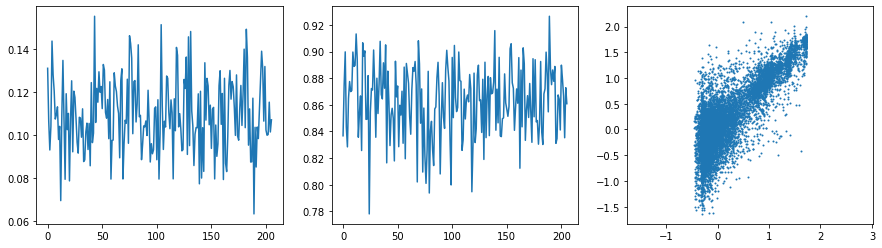

valid loss:  0.13125172621485862
valid correlation:  0.8308088741784256


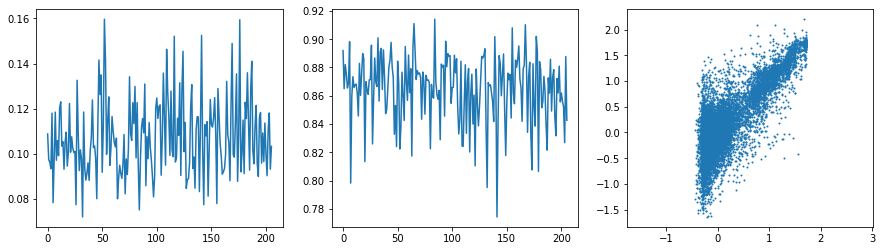

valid loss:  0.12956523455002092
valid correlation:  0.8316682484322688


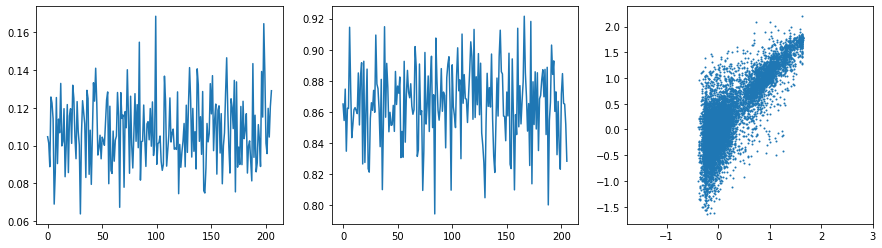

valid loss:  0.12861664914949375
valid correlation:  0.8343658925704278


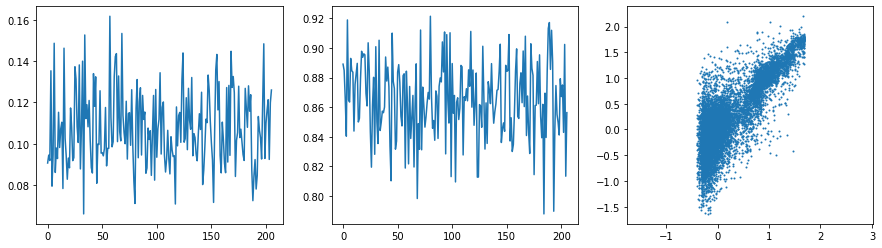

valid loss:  0.12937636698850177
valid correlation:  0.8312990065187293


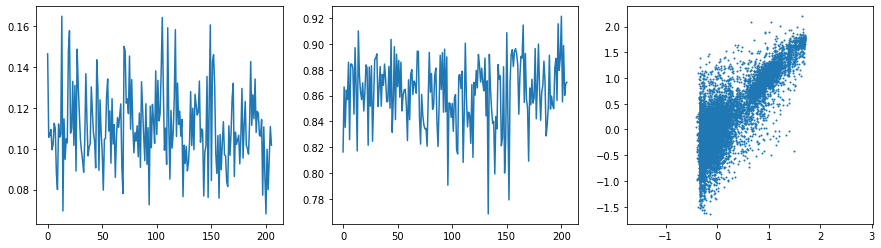

valid loss:  0.1295810609378598
valid correlation:  0.8317710880149033


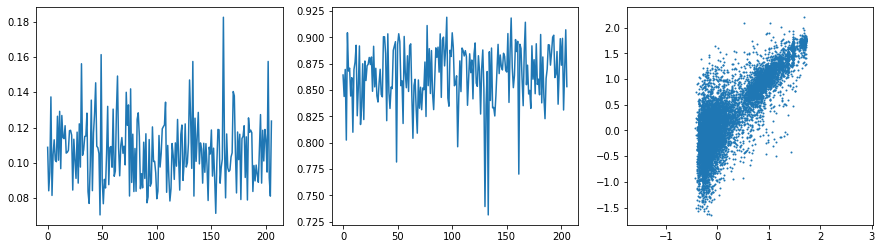

valid loss:  0.12941315617750992
valid correlation:  0.8335784454589223


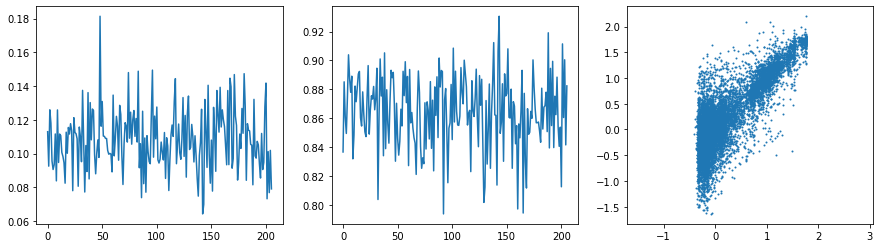

valid loss:  0.12895391932265324
valid correlation:  0.8320749011177949


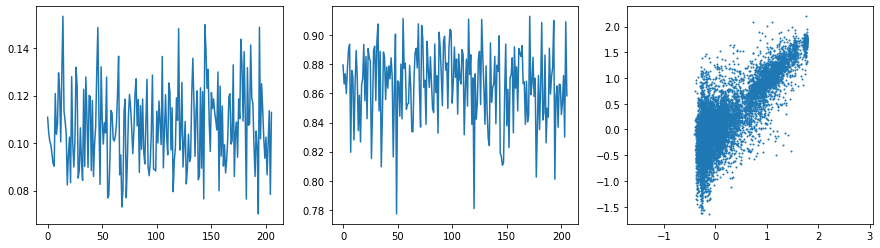

valid loss:  0.13008958372202786
valid correlation:  0.8333712321374782


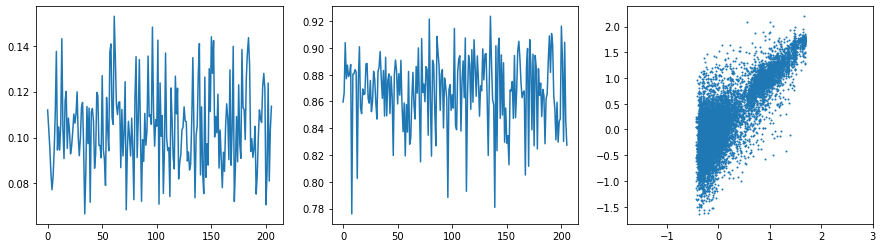

valid loss:  0.13028125041587788
valid correlation:  0.8313523250982533


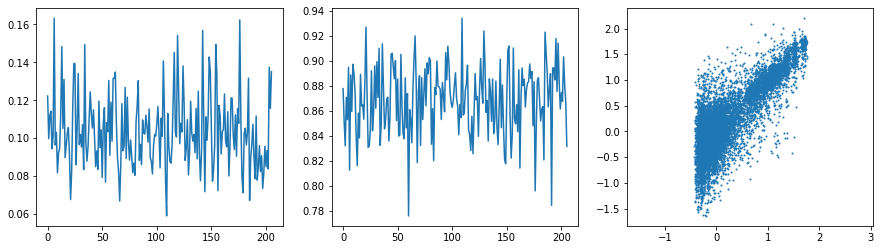

valid loss:  0.13003138749098236
valid correlation:  0.8322555482307159


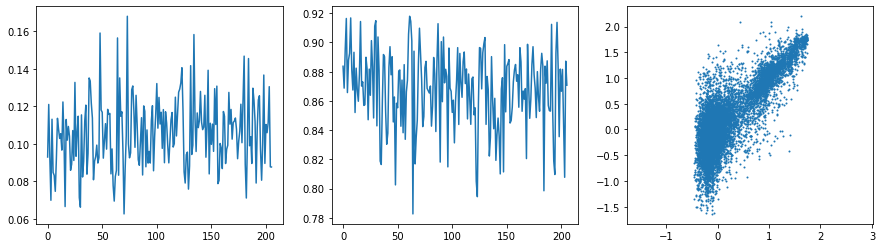

valid loss:  0.12957480118017306
valid correlation:  0.8310630830457971


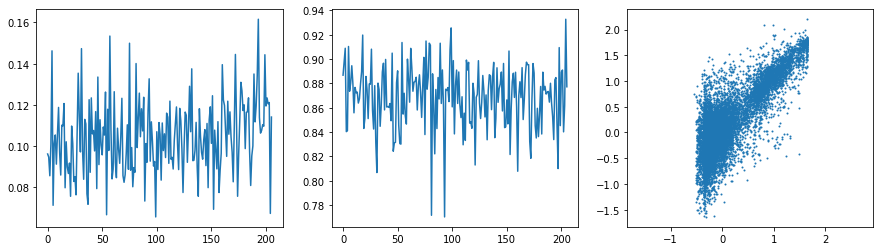

valid loss:  0.13439822036095642
valid correlation:  0.8303203653298759


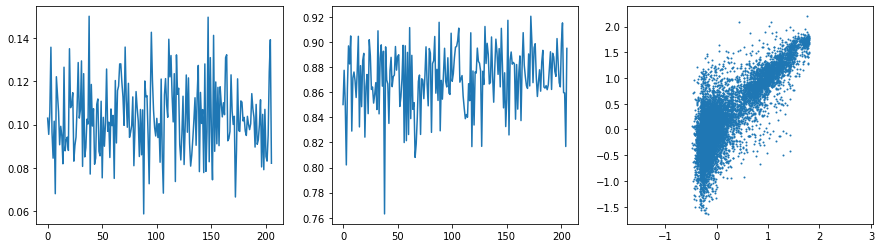

valid loss:  0.12923206913877616
valid correlation:  0.8336703230025964


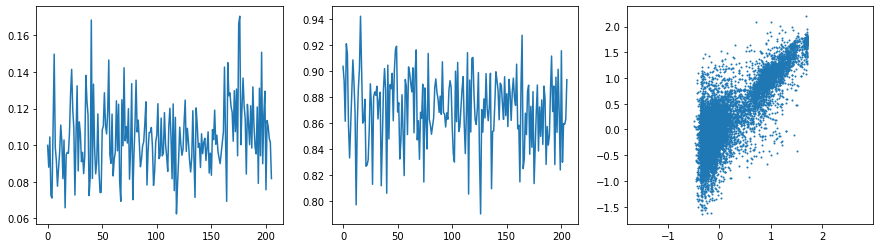

valid loss:  0.13199346986683932
valid correlation:  0.8313635158773205


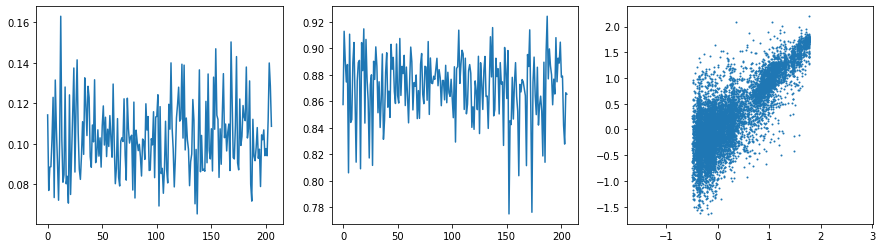

valid loss:  0.13762615892020139
valid correlation:  0.8270903657273163


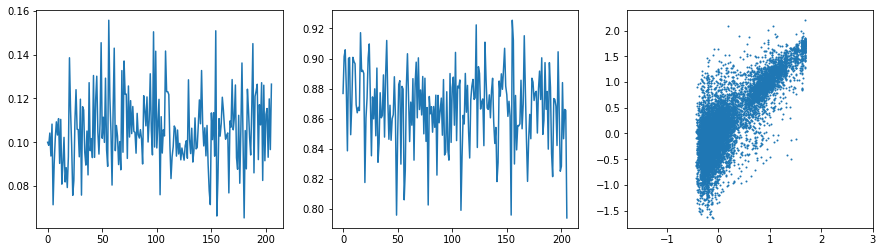

valid loss:  0.13223079456524414
valid correlation:  0.8278298917138063


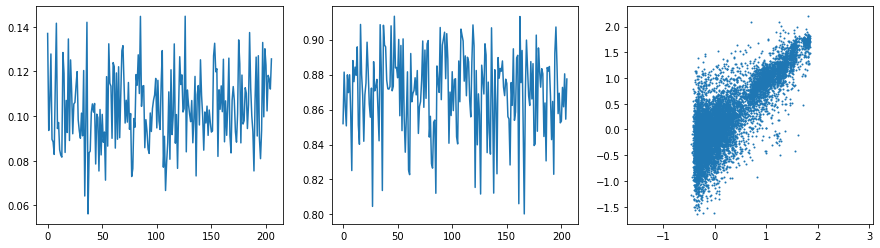

valid loss:  0.13439319299703295
valid correlation:  0.8304308504880422


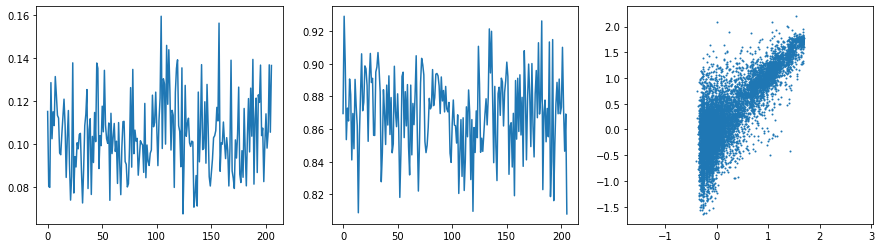

valid loss:  0.13140655715357175
valid correlation:  0.8289781579002922


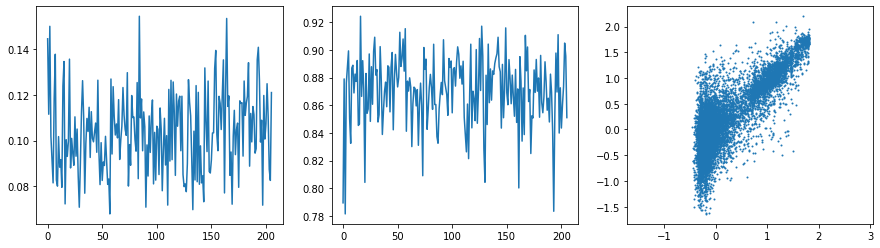

valid loss:  0.1320933863012628
valid correlation:  0.8323924349673973


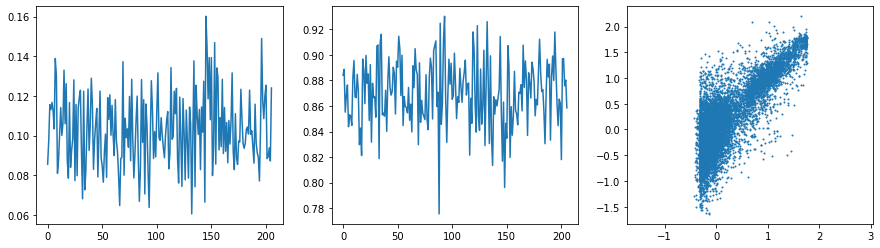

valid loss:  0.12954562512988393
valid correlation:  0.8312835999614105


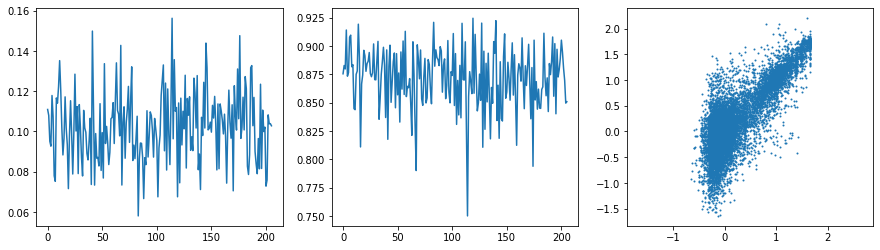

valid loss:  0.12916665981439027
valid correlation:  0.8314425421752798


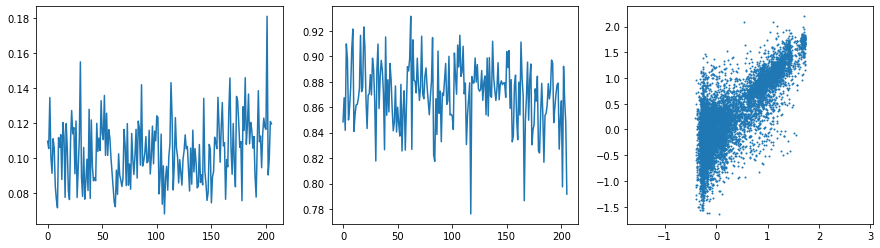

valid loss:  0.13597464104267684
valid correlation:  0.8250651211920584


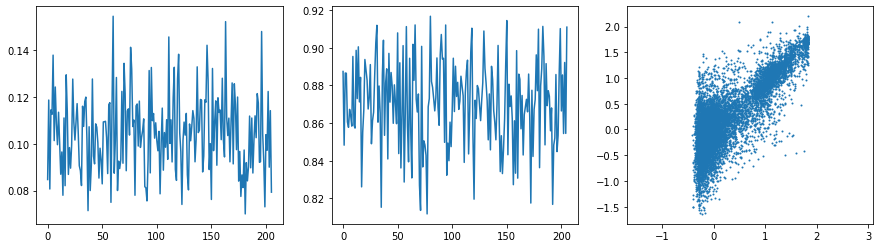

valid loss:  0.13697655879977075
valid correlation:  0.8298175189604264


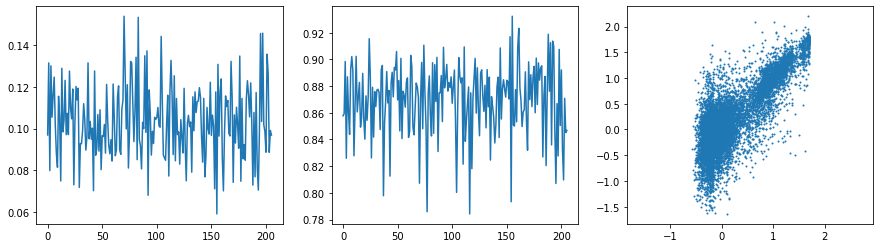

valid loss:  0.13225740829313343
valid correlation:  0.8288344132218007


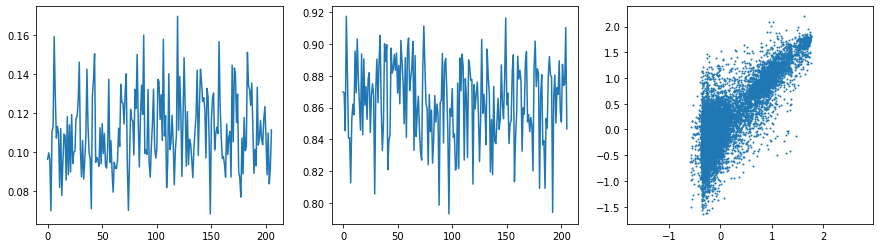

valid loss:  0.13236829181286422
valid correlation:  0.8309181993075012


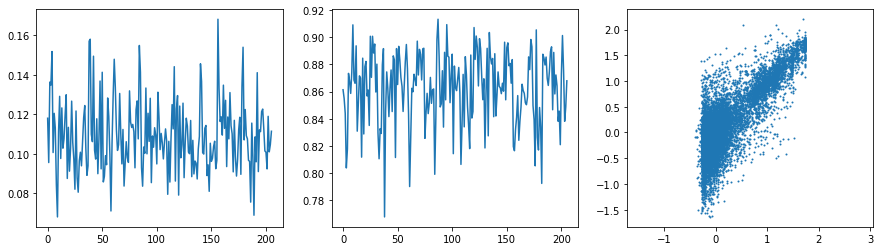

valid loss:  0.13209838403219526
valid correlation:  0.8312133611329493


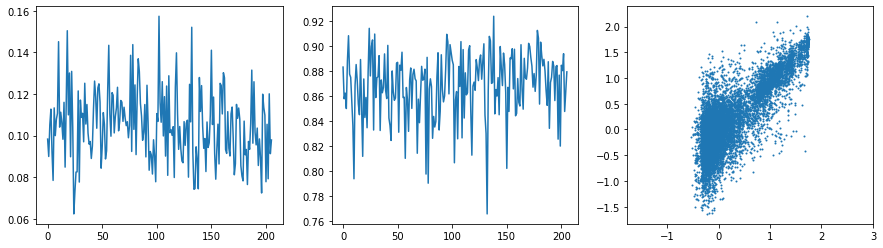

valid loss:  0.13520462497730146
valid correlation:  0.8293542641597784


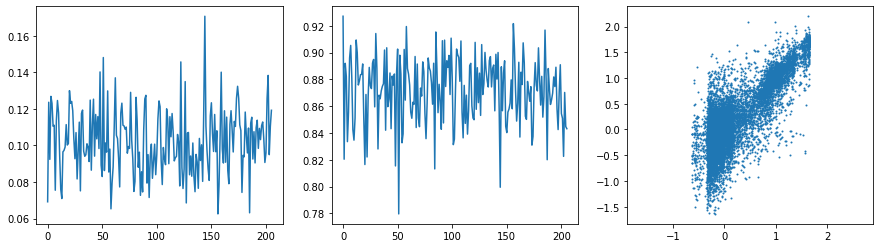

valid loss:  0.1329680790447376
valid correlation:  0.8278355592838516


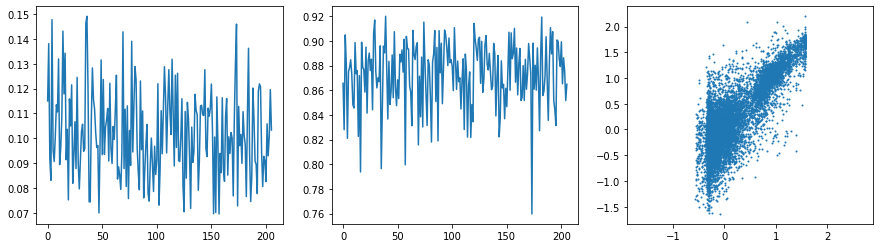

valid loss:  0.13133268227631395
valid correlation:  0.830485071510695


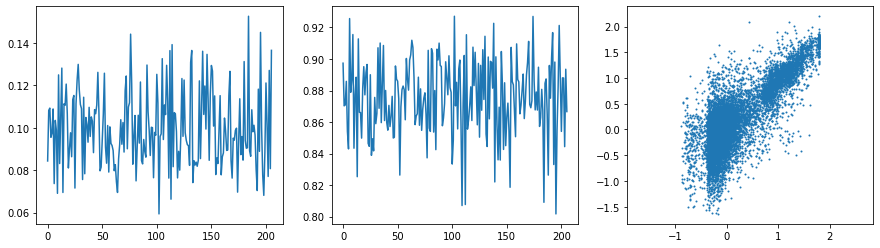

valid loss:  0.1358218871226365
valid correlation:  0.8291596723319671


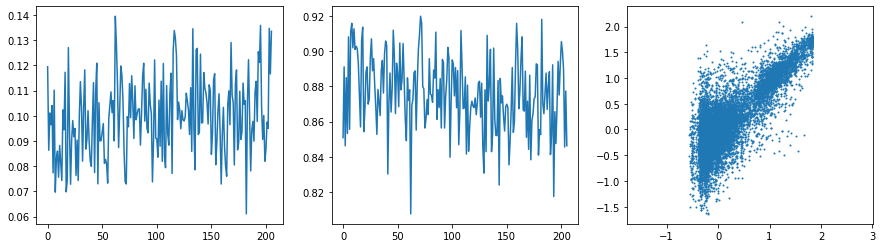

valid loss:  0.1372974949296225
valid correlation:  0.8287503329578361


KeyboardInterrupt: ignored

In [128]:

epochs = 200
TRAIN_LOSS = []
TEST_LOSS = []
TRAIN_CORR = []
TEST_CORR = []
plt.rcParams['figure.figsize'] = (15, 4)
for epoch in range(epochs):
    losses = []
    pcces = []
    for batch in dl_train:
        loss1, pcc = train_step(model, batch[0], batch[1], batch[2])
        losses.append(loss1)
        pcces.append(pcc)
    TRAIN_LOSS.append(sum(losses) / len(losses))
    TRAIN_CORR.append(sum(pcces) / len(pcces))
    plt.subplot(1,3,1)
    plt.plot(losses)
    plt.subplot(1,3,2)
    plt.plot(pcces)
    
    losses = []
    pcces = []
    preds = []
    labels = []
    for batch in dl_test:
        features = batch[0]#[mask]
        label = batch[1]#[mask]
        loss2, predictions = valid_step(model, features, label, batch[2])
        losses.append(loss2)
        for i in range(predictions.shape[0]):
          preds.append(predictions[i].cpu().numpy().item())
          labels.append(label[i].cpu().numpy().item())

    pccs = pearsonr(np.array(preds), np.array(labels))[0]
    TEST_LOSS.append(sum(losses) / len(losses))
    TEST_CORR.append(pccs)
    plt.subplot(1,3,3)
    plt.scatter(preds, labels, s=1)
    plt.axis("equal")
    plt.show()
    print("valid loss: ", sum(losses) / len(losses))
    print("valid correlation: ", pccs)

    if TEST_CORR[-1] == max(TEST_CORR): 
      print("sota!")
      torch.save(model.state_dict(), "./drive/MyDrive/ESM/LSTM_with_Contact_Map.pkl")
    

    
    


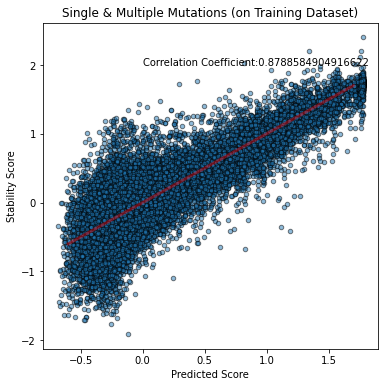

In [ ]:
preds = []
labels = []

for batch in dl_train:
    model.eval()

    with torch.no_grad():
        predictions = model(batch[0].to(device), batch[2].to(device)).reshape(-1)
    for i in range(predictions.shape[0]):
      preds.append(predictions[i].cpu().numpy().item())
      labels.append(batch[1][i].cpu().numpy().item())

plt.rcParams['figure.figsize'] = (6, 6)
plt.scatter(preds, labels, s=20, alpha=0.5, edgecolors="black")
plt.text(x=0, y=2, s="Correlation Coefficient:"+str(pearsonr(np.array(preds), np.array(labels))[0]))
plt.plot((-0.6, 1.7), (-0.6, 1.7), "red", alpha=0.4, linewidth=3)
#plt.axis("equal")
plt.ylabel("Stability Score")
plt.xlabel("Predicted Score")
plt.title("Single & Multiple Mutations (on Training Dataset)")
plt.show()

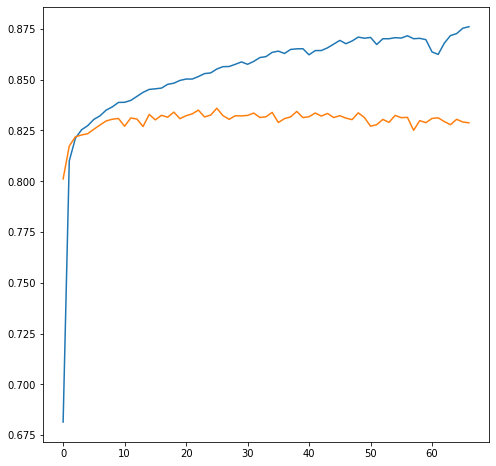

In [129]:
plt.rcParams['figure.figsize'] = (8, 8)
plt.plot(TRAIN_CORR)
plt.plot(TEST_CORR)